Questo è il codice che include il lavoro fatto sulle basi del lab meeting tenuto in data 02 05 22


In [1]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["RBM_Padella2.py", "DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/DBN/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import RBM_Padella2
import RBM
import DBN

--2022-05-04 20:36:22--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/RBM_Padella2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8766 (8.6K) [text/plain]
Saving to: ‘RBM_Padella2.py’

RBM_Padella2.py     100%[===================>]   8.56K  --.-KB/s    in 0s      

2022-05-04 20:36:22 (51.2 MB/s) - ‘RBM_Padella2.py’ saved [8766/8766]

--2022-05-04 20:36:22--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/DBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5198 (5.1K) [text/plain]
Saving to: ‘DBN

In [2]:
# Importing the libraries
#from RBM_Padella2 import RBM
from DBN import DBN

from RBM import RBM

import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import os
import random

import time

In [ ]:
'''
TO RETRIEVE TRAINED MODELS FROM GDRIVE

The cell will return the following and your needs to go 
to the link to retrieve the authorization code. Then you are good to go!
'''

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.

    This code is the same as that found from many public Kaggle kernels.

    Parameters
    ----------
    seed: int
        seed value to ues

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
#device in use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

Using device cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

The number shown is the number: 2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


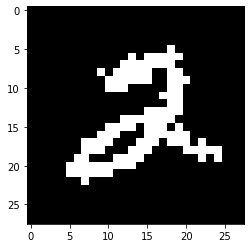

In [5]:
#importo dati mnist e binarizzo

#Loading MNIST dataset
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()
#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [6]:
rbm_mnist = RBM(visible_units=28*28 ,
              hidden_units= 23*23 ,
              k = 5,
              learning_rate = 0.01,
              learning_rate_decay = True,
              xavier_init = True,
              increase_to_cd_k = False,
              use_gpu = False) #nota: use_gpu ora e useless

In [ ]:
#dbn_mnist.train_static(mnist_data.data,mnist_data.train_labels,num_epochs , batch_size)
tmp = mnist_data.data
train_labels = mnist_data.train_labels
batch_size = 50
num_epochs = 200


tensor_x = tmp.type(torch.FloatTensor).to(DEVICE) # transform to torch tensors
tensor_y = train_labels.type(torch.FloatTensor).to(DEVICE)
_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
_dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader




start = time.time()

Avg_cost, Std_cost = rbm_mnist.train( _dataloader , num_epochs, batch_size)

end = time.time()

print(end - start)



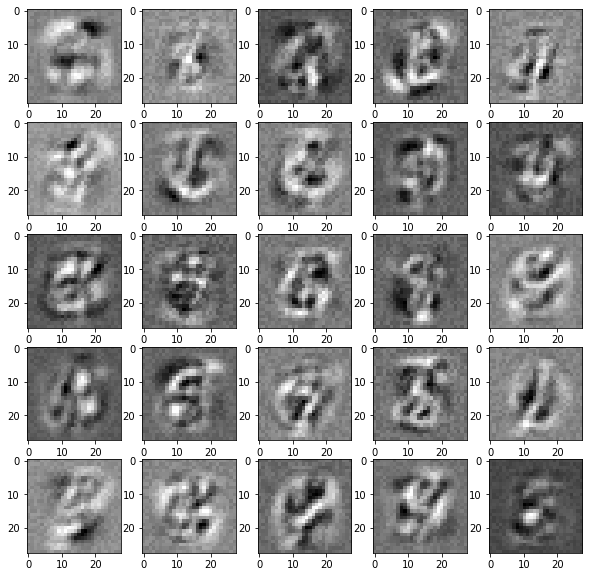

In [7]:
# visualising layer 1
learned_weights = rbm_mnist.W.cpu().transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

The original number: 6


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


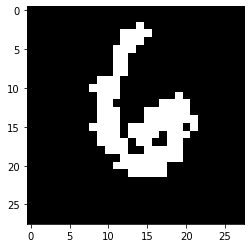

The reconstructed image


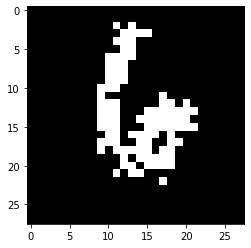

In [19]:
#recostruction check

idx = random.randint(0,len(mnist_data.train_data))
img = mnist_data.train_data[idx]
reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

_,reconstructed_img= rbm_mnist.reconstruct(reconstructed_img,1)


reconstructed_img = reconstructed_img.view((28,28)).cpu()
print("The original number: {}".format(mnist_data.train_labels[idx]))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()

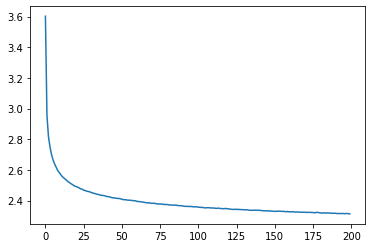

In [20]:
plt.plot(Avg_cost.cpu().numpy())